# Génération d'un graphe non orienté aléatoire avec matrice d'adjacence pondérée
Ce notebook a pour objectif de générer un graphe non orienté, connexe et complet, avec des pondérations aléatoires représentant les coûts des routes.
Il permet également de simuler des routes en travaux (inutilisables) et de visualiser le graphe.

Nous utilisons :

- **NetworkX** pour la manipulation des graphes,

- **NumPy** pour la gestion des matrices,

- **Matplotlib** pour l'affichage visuel.

In [5]:
# Importation des bibliothèques nécessaires
import networkx as nx        # Manipulation de graphes
import numpy as np           # Création et gestion de matrices
import random                # Génération aléatoire de données
import matplotlib.pyplot as plt  # Affichage graphique
import pandas as pd #export csv
import os #export csv

In [1]:
# Fonction pour générer une matrice d'adjacence pondérée et l'ordre des villes à traverser
def generer_matrice_avec_ordre(n_sommets, cout_max=10, taux_travaux=0.2):
    # Création d'une matrice vide de taille n_sommets x n_sommets, initialisée à 0
    matrice = np.zeros((n_sommets, n_sommets), dtype=int)
    
    # Étape 1 : Génération d’un arbre couvrant pour garantir la connexité du graphe
    sommets = list(range(n_sommets))
    random.shuffle(sommets)  # Mélange des sommets pour créer des arêtes aléatoires
    
    # Création de l'arbre couvrant (cela garantit la connexité du graphe)
    for i in range(n_sommets - 1):
        a, b = sommets[i], sommets[i + 1]  # Sélection aléatoire de deux sommets à connecter
        cout = random.randint(1, cout_max)  # Génération aléatoire du coût pour cette arête
        matrice[a][b] = cout  # Ajout de l'arête dans la matrice d'adjacence
        matrice[b][a] = cout  # La matrice est symétrique pour un graphe non orienté
    
    # Étape 2 : Compléter la matrice pour obtenir un graphe complet
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):  # Nous parcourons uniquement les éléments au-dessus de la diagonale
            if matrice[i][j] == 0:  # Si l'arête n'existe pas encore (valeur 0)
                if random.random() < taux_travaux:  # Si un taux de travail est rencontré, rendre l'arête inutilisable
                    val = -1  # Route en travaux
                else:
                    val = random.randint(1, cout_max)  # Génération d'un coût aléatoire pour une route praticable
                matrice[i][j] = val  # Ajout de l'arête dans la matrice
                matrice[j][i] = val  # La matrice est symétrique pour un graphe non orienté
    
    np.fill_diagonal(matrice, 0)  # On ne laisse aucune boucle (i.e., une arête reliant un sommet à lui-même)
    
    # Étape 3 : Ordonnancement aléatoire des villes à traverser
    villes_a_ordonner = random.sample(range(n_sommets), k=int((n_sommets/2)))  # Sélection d'un sous-ensemble de villes à ordonnancer
    ordre = random.sample(villes_a_ordonner, len(villes_a_ordonner))  # Ordre de passage aléatoire
    
    # Ajout 1 à chaque ville pour que l'ordre commence à 1
    ordre = [v + 1 for v in ordre]
    
    print(f"Ordre de passage des villes : {ordre}")
    
    # Modification des coûts pour refléter l'ordonnancement
    for i in range(len(ordre) - 1):
        a, b = ordre[i], ordre[i + 1]  # Connexion entre les villes dans l'ordre
        matrice[a - 1][b - 1] += 10  # Augmentation du coût pour l'ordre de passage
        matrice[b - 1][a - 1] += 10  # Assurer la symétrie

    # Étape 4 : Vérification de la connexité du graphe
    G = nx.Graph()  # Création d'un objet graphe vide avec NetworkX
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):  # On parcourt toutes les paires de sommets
            if matrice[i][j] > 0:  # Seules les arêtes avec un coût positif sont ajoutées
                G.add_edge(i, j)  # Ajout de l'arête au graphe

    # Si le graphe n'est pas connexe, on ajoute des arêtes pour le rendre connexe
    if not nx.is_connected(G):  # Vérification de la connexité
        composants = list(nx.connected_components(G))  # Identification des composants connexes
        for k in range(len(composants) - 1):  # Si plusieurs composants existent, les relier
            u = random.choice(list(composants[k]))  # Choisir un sommet de chaque composant
            v = random.choice(list(composants[k + 1]))
            cout = random.randint(1, cout_max)  # Générer un coût pour l'arête
            matrice[u][v] = cout  # Ajouter l'arête au graphe
            matrice[v][u] = cout  # Assurer la symétrie

    return matrice, ordre  # Retourner la matrice d'adjacence et l'ordre des villes

## Fonction : `generer_matrice_avec_ordre`

Cette fonction génère une **matrice d’adjacence** représentant un graphe **connexe et complet**, avec :
- Un **arbre couvrant** pour assurer la connexité
- Un **remplissage aléatoire** pour obtenir la complétude
- Un **taux de routes en travaux** (valeur `-1`)
- Un **ordre de passage des villes** aléatoire

Elle garantit que toutes les paires de sommets sont connectées, même si certaines routes sont inutilisables (en travaux).


In [2]:
# Fonction pour afficher la matrice d'adjacence sous forme de liste lisible
def afficher_matrice_liste(matrice):
    # Affichage lisible de la matrice sous forme de liste de listes
    print("[")
    for ligne in matrice:
        print("    " + str(list(map(int, ligne))) + ",")
    print("]")

## Fonction : `afficher_matrice_liste`

Cette fonction affiche la matrice d’adjacence sous la forme d’une **liste de listes**.
Cela permet une lecture plus claire qu’un simple affichage brut avec NumPy.


In [9]:
# Fonction pour afficher le graphe sous forme de visualisation
def afficher_graphe(matrice):
    G = nx.Graph()  # Création d'un graphe vide
    
    n_sommets = len(matrice)  # Nombre de sommets dans la matrice
    
    # Ajout des arêtes au graphe en fonction de la matrice d'adjacence
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):
            poids = matrice[i][j]  # Poids de l'arête entre les sommets i et j
            if poids != 0:  # On ignore les arêtes ayant un poids de 0 (diagonales)
                # Ajout de l'arête avec l'attribut 'travaux' pour savoir si l'arête est en travaux
                G.add_edge(i + 1, j + 1, weight=poids, travaux=(poids == -1))

    # Positionnement des sommets de manière automatique
    pos = nx.spring_layout(G, seed=42)
    
    # Définition des couleurs des arêtes : rouge pour les routes en travaux, gris pour les autres
    edge_colors = ['red' if G[u][v]['travaux'] else 'gray' for u, v in G.edges()]
    
    # Préparation des étiquettes des arêtes (affichage des poids sauf pour les routes en travaux)
    edge_labels = {
        (u, v): ('' if G[u][v]['travaux'] else G[u][v]['weight']) for u, v in G.edges()
    }

    # Affichage du graphe avec Matplotlib
    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos, with_labels=True, node_color='skyblue', node_size=600,
        edge_color=edge_colors, width=2, font_weight='bold'
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    plt.title("Graphe Complet – Routes praticables (gris), en travaux (rouge)")
    plt.show()

## Fonction : `afficher_graphe`

Cette fonction convertit la matrice d’adjacence en un graphe `NetworkX` et l'affiche visuellement avec `Matplotlib`.

- Les **routes praticables** (coût > 0) sont en **gris** avec leur poids.
- Les **routes en travaux** (coût = -1) sont en **rouge**, sans étiquette de poids.


In [ ]:
# Fonction pour exporter la matrice et l'ordre des villes au format CSV
def exporter_csv(matrice, ordre, nom_fichier="matrice_routes_ordre.csv"):
    chemin_fichier = os.path.join("data", nom_fichier)  # Définition du chemin d'exportation
    
    # Création du DataFrame pour la matrice d'adjacence
    df_matrice = pd.DataFrame(matrice)
    
    # Création du DataFrame pour l'ordre des villes
    df_ordre = pd.DataFrame([ordre])
    
    # Exportation des données au format CSV
    with open(chemin_fichier, mode="w", newline="") as f:
        df_matrice.to_csv(f, header=False, index=False, sep=";")  # Export de la matrice
        f.write("\n")  # Ligne vide pour séparer les deux sections
        df_ordre.to_csv(f, header=False, index=False, sep=";")  # Export de l'ordre des villes
    
    print(f"Matrice et ordre exportés avec succès vers « {nom_fichier} »")


## Fonction : `exporter_csv`

Cette fonction exporte la matrice d’adjacence et l’ordre des villes dans un fichier CSV, dans un dossier `data/`.

Le fichier CSV contient :
- La **matrice d’adjacence** (séparée par `;`)
- Une **ligne vide**
- Une **ligne contenant l’ordre de passage des villes**


Ordre de passage des villes : [6, 10, 8, 3, 9]
[
    [0, 188, 49, -1, -1, 154, 184, 130, 7, 131],
    [188, 0, 188, 107, -1, 107, 121, 179, 24, 166],
    [49, 188, 0, 100, 145, 149, 60, 31, 9, 189],
    [-1, 107, 100, 0, 141, 183, 65, 43, 144, 134],
    [-1, -1, 145, 141, 0, -1, -1, 100, 130, -1],
    [154, 107, 149, 183, -1, 0, 163, -1, 77, 99],
    [184, 121, 60, 65, -1, 163, 0, 88, 70, 30],
    [130, 179, 31, 43, 100, -1, 88, 0, 21, 52],
    [7, 24, 9, 144, 130, 77, 70, 21, 0, 157],
    [131, 166, 189, 134, -1, 99, 30, 52, 157, 0],
]


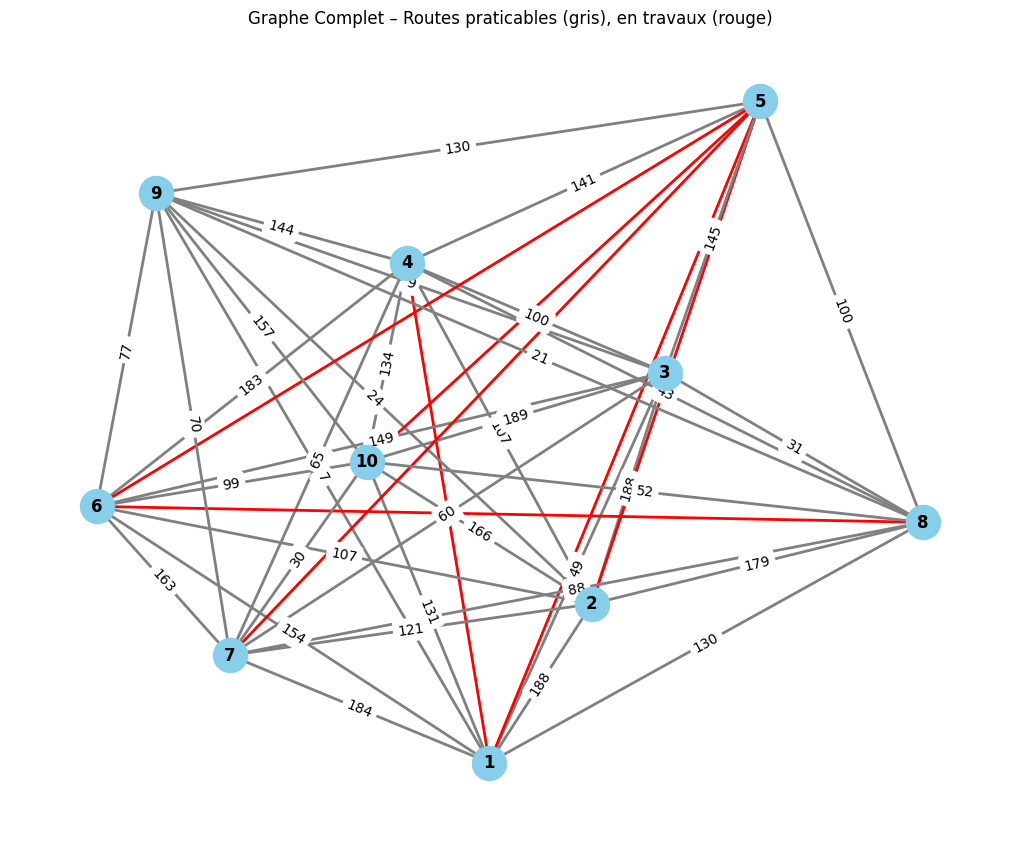

Matrice et ordre exportés avec succès vers « matrice_routes.csv »


In [14]:
# Génère la matrice avec l'ordonnancement
matrice, ordre = generer_matrice_avec_ordre(n_sommets=10, cout_max=200, taux_travaux=0.2)

# Affichage de la matrice
afficher_matrice_liste(matrice)

# Visualisation du graphe
afficher_graphe(matrice)

# Exportation de la matrice
exporter_csv(matrice, ordre)


Cette cellule utilise les fonctions précédentes pour :
- Générer une matrice de graphe avec 8 sommets, sans routes absentes.
- Afficher la matrice correspondante.
- Visualiser le graphe avec les routes praticables et celles en travaux.
